volver [analisis exploratorio de ventas](./01-analisis-exploratorio-ventas.ipynb)

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import plot_importance, plot_tree

import warnings
warnings.filterwarnings('ignore')

# Predicción de ventas general
En este apartado trataremos de hacer una predicción general sobre las ventas para todos los negocios. 

Nos apoyaremos en los datos de "00-ventas.parquet" que se generó en la anterior notebook.

Primero realizaremos unas transformaciones a los datos, luego ingresaremos estos datos al algoritmo, en este caso es xgboost y random forest. 
Podemos encontrar más información de xgboost [aquí](https://www.kaggle.com/jonathanloscalzo/xgboost)
Xgboost es una librería que aplica el concepto de "gradient boosting", en el que se producen modelos con predicciones débiles, y se concatenan para predecir un resultado mejor.

Luego realizaremos las mismas pruebas con [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html). Este tipo de algoritmo es un algoritmo de "bagging", similar al anterior algoritmo solo que en vez de concatenar los resultados, se agrupan y se obtiene un promedio de estos modelos de aprendizaje débiles.

La predicción que vamos a realizar será de las ventas del mes de diciembre de 2014, pero en vez de realizarlas por puntos de ventas, vamos a hacerlas de manera general. Probaremos los dos algoritmos con sus valores por defecto y luego intentaremos optimizarlos para mejorar un poco dicha predicción.

Vamos a dividir el proceso en:
- obtención
- transformación
- train
- test
- visualización



## Obtención de los datos
Leemos los datos del archivo parquet que generamos

In [2]:
df_ventas = pd.read_csv('./data/ventas.txt', delimiter = "|", infer_datetime_format=True, parse_dates=[0])
df_ventas = df_ventas.drop('canal', axis=1)
df_ventas = df_ventas.drop(df_ventas.loc[lambda df: df.unidades <=0].index)

In [3]:
# como vamos a predecir ventas, las agrupamos por fecha y nos quedamos con las unidades
df_unidades = df_ventas.groupby('fecha').unidades.sum().to_frame()

# generamos un dataframe fechas, que contiene todas las fechas de las ventas.
fechas = df_unidades.reset_index().loc[:,["fecha"]]

Realizamos un gráfico para verificar que los datos son correctos.

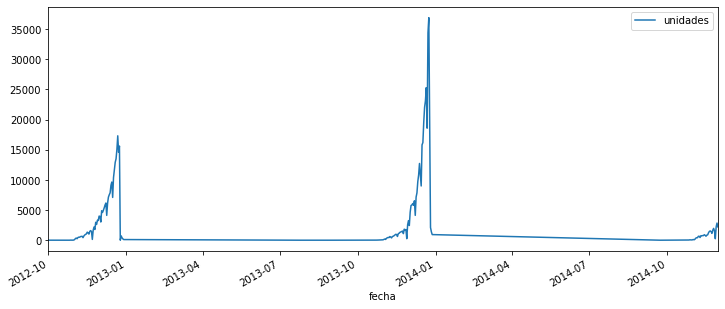

In [4]:
df_unidades.plot.line(figsize=(12,5))

## Transformación
Comenzaremos a transformar los datos de entrada, carácteristicas o features, para que nuestros algoritmos comiencen a aprender. Estos algoritmos tienen la particularidad que trabajan con atributos númericos, por ende tendremos que descomponer la fecha en valores númericos que nos interesen. Este paso suele recibir el nombre de "Feature Engineering"


In [5]:
def add_date_features(df, col_name="fecha"):
    """
    Esta función transforma una columna que se recibe como parámetro, 
    en varias columnas derivadas. 
    
    """
    df['date'] = df[col_name]
    df['dayofweek'] = df['date'].dt.dayofweek
    # más abajo se descubre que esta columna está correlacionada con dayofyear y weekofyear
    df['month'] = df['date'].dt.month 
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df = df.drop([col_name,'date'], axis=1, errors='ignore')
    
    return df

In [6]:
df_unidades = add_date_features(df_unidades.reset_index())
df_unidades.shape

(276, 7)

In [7]:
df_unidades.head()

,unidades,dayofweek,month,year,dayofyear,dayofmonth,weekofyear
0,4,0,10,2012,275,1,40
1,1,2,10,2012,284,10,41
2,1,3,10,2012,285,11,41
3,3,4,10,2012,286,12,41
4,1,5,10,2012,287,13,41


## Entrenamiento
Separamos el dataset en train y test

In [8]:
X = df_unidades.iloc[:,1:9]
y = df_unidades.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False, random_state=7)

Instanciamos nuestros algoritmo, y los entrenamos con nuestros datasets de pruebas.
Realizamos un adapter para Xgboost ya que los parámetros que tiene el train, no corresponden a los default de sklearn, donde la api de los algoritmos en el método "train" solo reciben X e y.

In [9]:

# https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst#learning-task-parameters

class XgboostAdapter: 
    
    _model = None
    
    def __init__(self, eval_set=None, eval_metric=None, early_stopping_rounds=None,  verbose=False):
        self._model = xgb.XGBRegressor(booster="gbtree", objective="reg:squarederror")
        self.eval_set = eval_set
        self.early_stopping_rounds = early_stopping_rounds
        self.verbose = verbose
    
    def fit(self, X, y):
        self._model.fit(X,
                         y, 
                         early_stopping_rounds= self.early_stopping_rounds,
                         eval_set = self.eval_set,
                         verbose = self.verbose
                        )
        
    def predict(self, X):
        return self._model.predict(X)
    
    @property
    def model(self):
        return self._model
    
    @model.setter
    def model(self, model):
        self._model = model
        return self._model
    

Agrupamos nuestros modelos en un arreglo para entrenarlos

In [10]:
models = [
    XgboostAdapter(eval_set=[(X_train, y_train), (X_test, y_test)], 
        early_stopping_rounds=50,
        verbose=False),
    RandomForestRegressor(criterion="mae")
]

In [11]:
for m in models:
    m.fit(X_train, y_train)

Hacemos un gráfico de las características más importantes, según nuestros modelos. 
Estos gráficos, nos devuelven la importancia de cada atributo a la hora de la elección de la predicción. (cuántas veces se hizo split por el atributo)

Según el modelo Xgboost, las 3 features más importantes en orden son: "weekofyear", ""dayofyear", "dayofmonth"
En el modelo RandomForest, las 3 features más importantes en orden son: "dayofyear", "dayofmonth", "weekofyear"


In [12]:
def plot_importance_reg(reg, columns, title):
    # https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regression-py
    
    top_n = 10
    feat_imp = pd.DataFrame({'importance':reg.feature_importances_})    
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=(12,6))
    plt.xlabel('Feature Importance Score')
    plt.show()


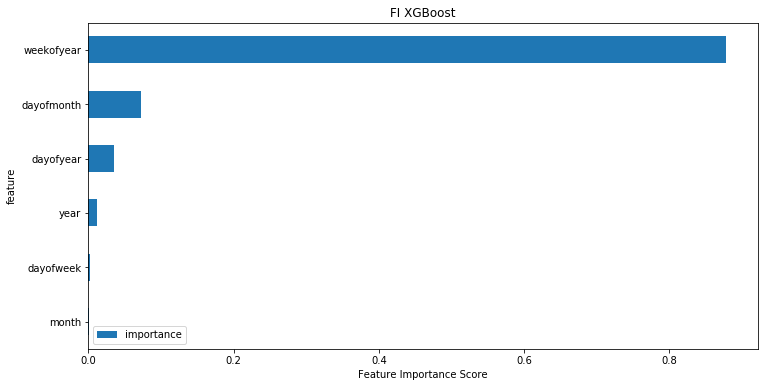

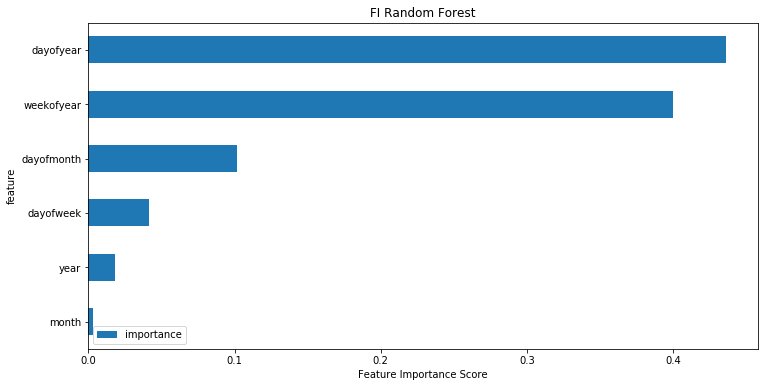

In [13]:
plot_importance_reg(models[0].model, X.columns, "FI XGBoost")
plot_importance_reg(models[1], X.columns, "FI Random Forest")

Si verificamos que tan correlacionados están los datos: 

In [14]:
X.corr()

,dayofweek,month,year,dayofyear,dayofmonth,weekofyear
dayofweek,1.000000,0.058562,0.007658,0.050221,-0.043331,0.005332
month,0.058562,1.000000,-0.233165,0.979863,-0.126452,0.978106
year,0.007658,-0.233165,1.000000,-0.234363,0.032536,-0.210748
dayofyear,0.050221,0.979863,-0.234363,1.000000,0.073863,0.998667
dayofmonth,-0.043331,-0.126452,0.032536,0.073863,1.000000,0.077039
weekofyear,0.005332,0.978106,-0.210748,0.998667,0.077039,1.000000


Observamos que el month está linealmente relacionado con weekofyear y dayofyear, el cual se desprende que se puede calcular a partir de cualquiera de los dos valores.

Redefinimos nuestra función, y ejecutamos los pasos nuevamente, quitando la columna month

In [15]:
X = X.drop('month', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [16]:
models = [
    XgboostAdapter(eval_set=[(X_train, y_train), (X_test, y_test)], 
        early_stopping_rounds=50,
        verbose=False),
    RandomForestRegressor(criterion="mae")
]

for m in models:
    m.fit(X_train, y_train)

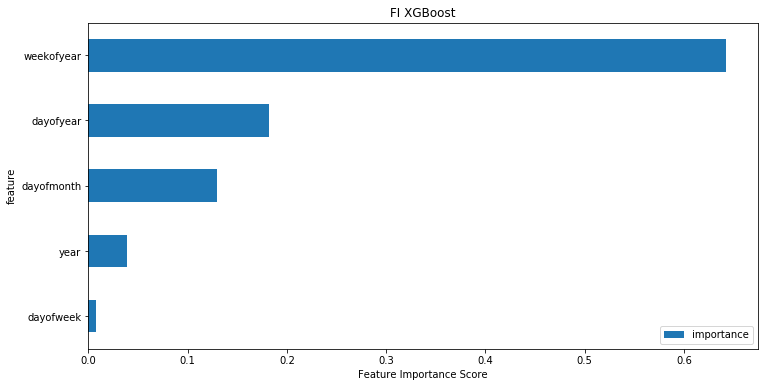

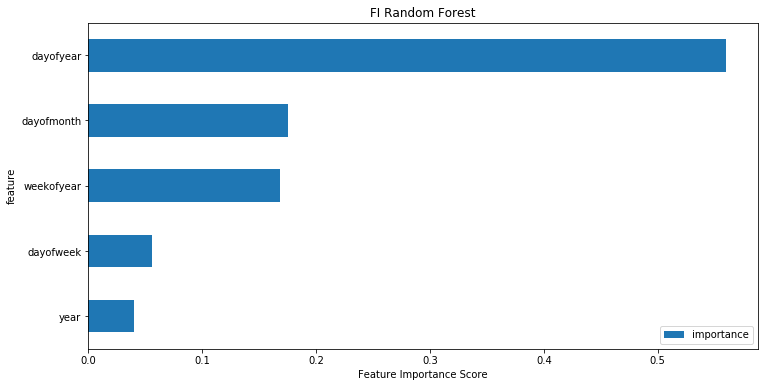

In [17]:
plot_importance_reg(models[0].model, X.columns, "FI XGBoost")
plot_importance_reg(models[1], X.columns, "FI Random Forest")

# Testeo
Vamos a comprobar nuestro modelo para conocer que tanto acierto tiene. Conocemos lo que es "compensación bias-variance" (o tradeoff en inglés). 

Bias hace referencia como son las predicciones de los datos con los que se entrenó el modelo.   
Variance hace referencia como son las predicciones en los datos que dividimos para test. 

La compensación se da de la siguiente manera:
- si nuestro modelo tiene mucho error al predecir los datos con los que fue entrenado, decimos que está underfit
- si nuestro modelo tiene mucho error al predecir los datos con los que es testeado, decimos que nuestro modelo está overfit


### Métricas
#### explained_variance_score
Es una medida de dispersión/varianza de la predicción. El mejor valor es 1, y mientras más bajo sea peor el resultado. 

#### Mean Absolute Error
El error absoluto medio se promedian todas las diferencias entre el valor real y la predicción.  
Cuanto más cercano a 0, mejor. 

#### R2 score
R2 o coeficiente de determinación.
Representa la proporción de varianza que ha sido explicado por las variables independientes del modelo. Provee un indicador de que tan bueno es el entrenamiento; es una medida de que tan bien los ejemplos son predecidos por el modelo a través de su varianza. (Relacionado con la métrica 1). El mejor valor posible es 1, y puede ser negativo para predicciones demasiado erroneas.

[Fuente](https://scikit-learn.org/stable/modules/model_evaluation.html)

In [18]:
def get_metrics(y_real, y_pred):
    return {
        # Best possible score is 1.0, lower values are worse.
        "explained_variance_score": metrics.explained_variance_score(y_real, y_pred),
        # The best value is 0.0. it is robust to outliers
        "mae": metrics.mean_absolute_error(y_real, y_pred),
        # computes the coefficient of determination, Best possible score is 1.0 and it can be negative
        "r2": metrics.r2_score(y_real, y_pred), 
    }

In [19]:
bias_predictions = [ m.predict(X_train) for m in models ]

for p, a in zip(bias_predictions, ["XGB", "RF"]):
    print(a, " ", get_metrics(y_train, p))
    

XGB   {'explained_variance_score': 0.9962529809917497, 'mae': 142.3785237796566, 'r2': 0.9962518024286174}
RF   {'explained_variance_score': 0.9726895689211961, 'mae': 297.02668393782386, 'r2': 0.9725917588920525}


Podemos observar en las métricas que las mejores fueron para RF por muy poco, es decir nuestros modelos no se encuentra por debajo del limite de bajo entrenamiento. Ahora realizamos las pruebas para con los datos de testeo. 

In [20]:
variance_predictions = [ m.predict(X_test) for m in models ]

for p, a in zip(variance_predictions, ["XGB", "RF"]):
    print(a, " ", get_metrics(y_test, p))

    

XGB   {'explained_variance_score': 0.7834518452273267, 'mae': 500.01211615068365, 'r2': 0.7810754760597671}
RF   {'explained_variance_score': 0.8756636028225985, 'mae': 539.7584337349397, 'r2': 0.8697487349008719}


Podemos observar que las métricas son más semejantes que en el caso anterior, es decir el modelo RandomForest se ajusta mejor a los datos de train que a los datos de test. 
Aunque ambos modelos se encuentran dentro de los valores esperados. Podríamos decir que RF parece estar overfitteado.

In [21]:
preds = [ m.predict(X) for m in models ]

for p, a in zip(preds, ["XGB", "RF"]):
    print(a, " ", get_metrics(y, p))
    

XGB   {'explained_variance_score': 0.9604142719637264, 'mae': 249.9277562680452, 'r2': 0.9602759901499447}
RF   {'explained_variance_score': 0.9560632354302864, 'mae': 370.0221014492754, 'r2': 0.955448948521087}


Las métricas con todos los datos para ambos modelos son semejantes, ligeramente xgb un poco mejor.

### Métricas: cross-validation
Las métricas de cross-validation nos permiten dividir nuestro dataset en grupos e iterar sobre el mismo, seleccionando algunos para testeo y otros para entrenamiento. Esto nos permite verificar los hiperparámetros con los que entrenamos el algoritmo.

Esta métrica quizás no tenga sentido, ya que según el rango de datos que elija, puede llegar a encontrar un espacio muy vacío, recordar que solamente hay datos entre noviembre y diciembre. Quizás, con un train and set, dividiendo el 70/30 para entrenamiento y testeo sea mas relevante a la hora de predecir una serie en el tiempo.

[Fuente](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)

In [22]:
results_cv = [ cross_val_score(
        m.model if i == 1 else m, 
        X, y, 
        scoring="r2", #"neg_mean_absolute_error", 
        cv=4)
     for m, i in zip(models, [1,2])]
results_cv = [ (r.mean()*100, r.std()**2*100) for r in results_cv ]

for r in results_cv:
    print("Exactitud (R2): %0.2f (+/- %0.2f)" % r)

Exactitud (R2): 78.02 (+/- 0.48)
Exactitud (R2): 64.21 (+/- 4.02)


## Modelo en acción
Utilizamos los modelos para realizar las predicción.
En primera instancia, mostramos los valores que predice el modelo para toda la serie en donde tenemos los datos. 

Podemos observar que las predicciones fueron aproximadamente similares para ambos casos. 

In [23]:
df_graph = fechas
df_graph.loc[:, "unidades"] = y
df_graph.loc[:, "unidades_xgb"] = preds[0] 
df_graph.loc[:, "unidades_rf"] = preds[1]

#### Predicciones para 2012

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9228cf6d30>,
      dtype=object)

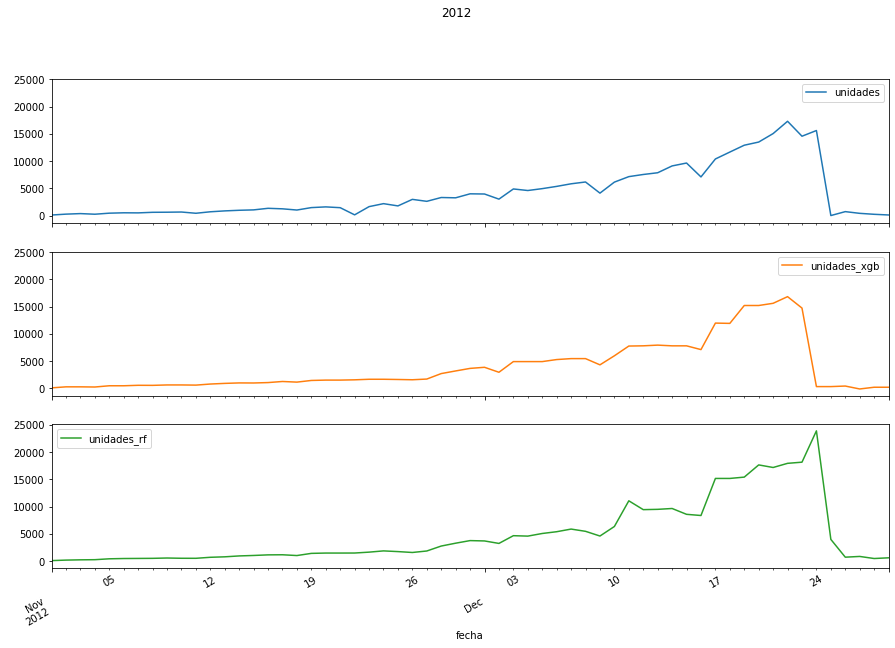

In [24]:
df_graph.set_index("fecha").loc["2012-11":"2012-12",:].plot.line(figsize=(15,10), subplots=True, title="2012", sharey=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f922895e160>,
      dtype=object)

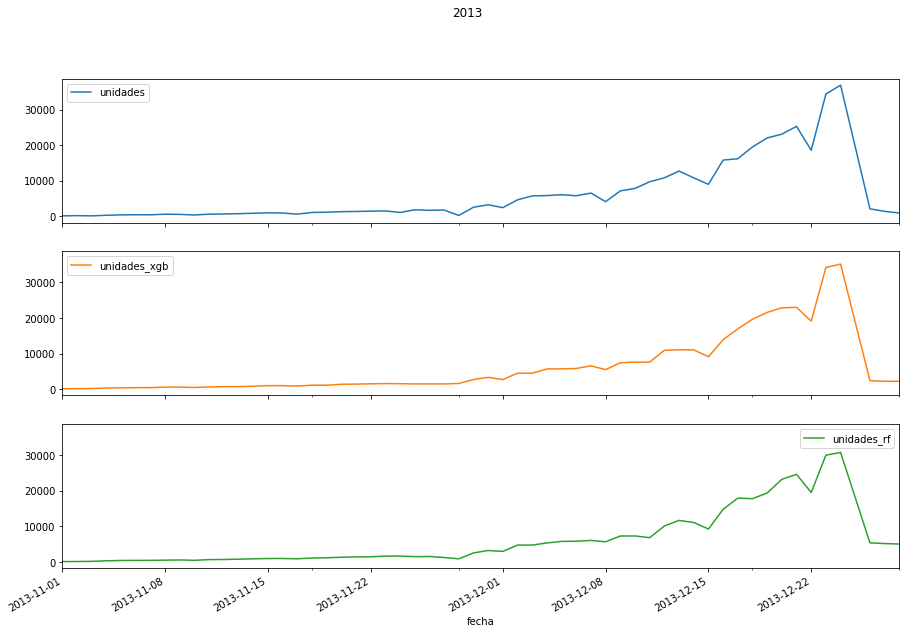

In [25]:
df_graph.set_index("fecha").loc["2013-11":"2013-12",:].plot.line(figsize=(15,10), subplots=True, title="2013", sharey=True)

#### Predicciones para 2013

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9228877320>,
      dtype=object)

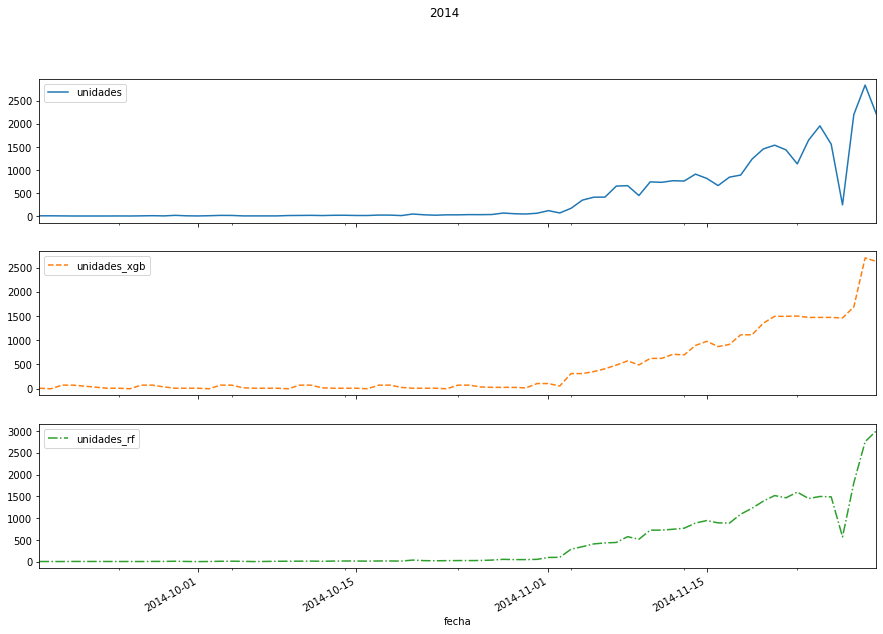

In [26]:
df_graph.set_index("fecha").loc["2014-08":"2014-12",:].plot.line(figsize=(15,10), subplots=True, title="2014", style=["-","--","-."])

Se puede observar que para el año 2014, las predicciones más cercanas fueron las de RandomForest, aunque en cambio en los otros años, los picos fueron más aproximados por Xgboost.
Si realizamos reitaradas pruebas de entrenamiento

Agregamos nuestra predicción final, de la cuál no tenemos datos para comprobar. La predicción corresponde al mes de diciembre de 2014

In [27]:
final = pd.date_range(start="2014-12-01", periods=31)
final = pd.DataFrame(final, columns=["fecha"])
final = add_date_features(final)
final = final.drop('month', axis=1)

In [28]:
#grafico esta muestra
result = (
    pd.DataFrame(
        pd.date_range(
            start="2014-12-01", 
            periods=31), 
        columns=["fecha"]
    ).set_index('fecha')
)

result.loc[:,"unidades_xgb"] = models[0].predict(final)
result.loc[:,"unidades_rf"] = models[1].predict(final)
result = (
    df_graph.set_index("fecha")[["unidades"]]
    .append(result, sort=True)
)

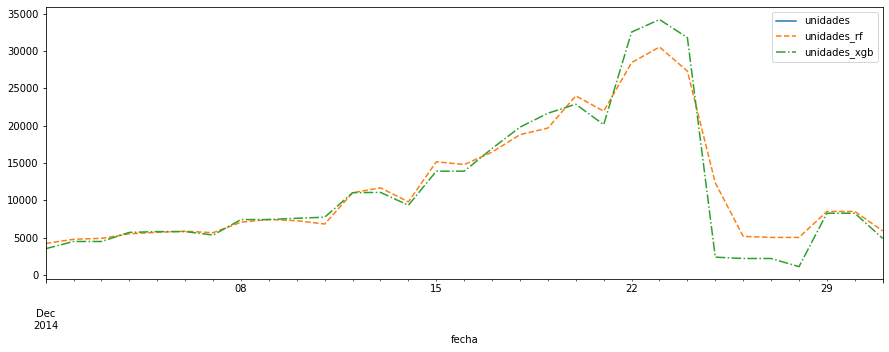

In [29]:
result.loc["2014-12"].plot.line(figsize=(15,5),  style=["-","--","-."])

Podríamos continuar nuestro ciclo, intentando cambiar los parámetros en los algoritmos para mejorar nuestras predicciones. Este paso se suele llamar "optimización de hiperparámetros". 

Dicho paso no lo vamos a tener en cuenta en este apartado, ya que analizaremos el archivo de puntos de ventas para su transformación y la obtención de algún modelo predictivo correspondiente al realizar la mezcla del archivo de fechas el anteriormente mencionado. En resumen, intentaremos predecir por punto de venta cuandas unidades podrá vender en el mes de diciembre.


// Damos por concluida esta sección